In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, pearsonr, linregress
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [2]:
DATA_PATH = "../data"

In [3]:
df = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df["ln_r_data"] = np.log(df["r_data"])

/opt/homebrew/Caskroom/miniconda/base/envs/py3/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
df_non_wc = df.query("r_type == 'NON-WC'")
df_wc = df.query("r_type == 'WC'")

In [5]:
df.columns

Index(['both_purine', 'both_pyrimidine', 'constructs', 'has_pdbs',
       'likely_pair', 'm_flank_bp_5p', 'm_flank_bp_3p', 'm_orientation',
       'm_pos', 'm_second_flank_bp_5p', 'm_second_flank_bp_3p', 'm_sequence',
       'm_structure', 'm_token', 'n_pdbs', 'pair_type', 'p5_res', 'p5_type',
       'p3_res', 'p3_type', 'r_data', 'r_nuc', 'r_loc_pos', 'r_pos', 'r_type',
       'ln_r_data'],
      dtype='object')

## probablity of being WC

In [10]:
filtered_column = df['r_data'][df['r_data'] != 0]
min_value = filtered_column.min()
print(min_value) # approximately ln(min_value) = -9.8


6.000000000000001e-05


In [11]:
# set -inf values to -9.8 the lowest value found
df['ln_r_data'].replace(-np.inf, -9.8, inplace=True)
df["ln_r_data"].describe()

count    237528.000000
mean         -5.090383
std           1.367047
min          -9.800000
25%          -6.319969
50%          -5.057727
75%          -3.966479
max          -0.691768
Name: ln_r_data, dtype: float64

In [12]:
# Convert 'r_type' to binary (1 for 'WC', 0 for 'NON-WC')
df['r_type_binary'] = df['r_type'].apply(lambda x: 1 if x == 'WC' else 0)
# Fit the logistic regression model
model = LogisticRegression()
model.fit(df[['ln_r_data']], df['r_type_binary'])
# Compute probabilities for the original data
df['prob_WC'] = model.predict_proba(df[['ln_r_data']])[:, 1]
# Display the probabilities
df.sort_values('prob_WC', ascending=False)[['ln_r_data', 'r_type', 'prob_WC']]

ln_r_data  r_type   prob_WC
136078  -9.800000      WC  0.999996
28731   -9.800000      WC  0.999996
66506   -9.800000      WC  0.999996
58333   -9.800000      WC  0.999996
8841    -9.800000      WC  0.999996
...           ...     ...       ...
234212  -1.013022  NON-WC  0.000003
234179  -0.994414  NON-WC  0.000003
55879   -0.972755  NON-WC  0.000003
55890   -0.853363  NON-WC  0.000002
234188  -0.691768  NON-WC  0.000001

[237528 rows x 3 columns]

In [40]:

# Calculate the absolute difference between each value in the column 'prob_WC' and 0.5
df['abs_diff'] = (df['prob_WC'] - 0.10).abs()

# Find the index of the minimum difference
min_index = df['abs_diff'].idxmin()

# Retrieve the entire row that is closest to 0.5 in the 'prob_WC' column
closest_row = df.loc[min_index]

print("The row with the value in 'prob_WC' closest to 0.5 is:")
print(closest_row["ln_r_data"])

The row with the value in 'prob_WC' closest to 0.5 is:
-4.684213393328545


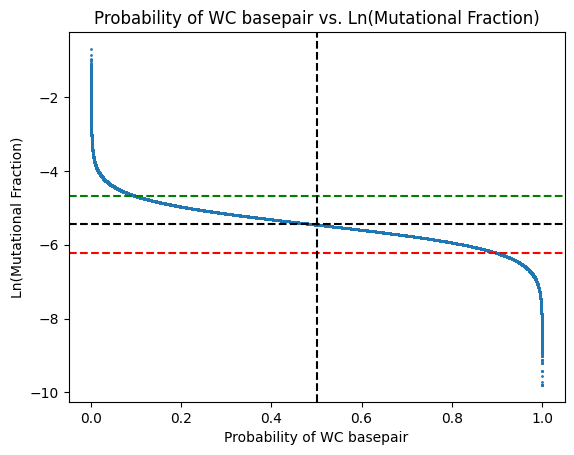

In [42]:
plt.scatter(df['prob_WC'], df['ln_r_data'], s=1)
plt.title('Probability of WC basepair vs. Ln(Mutational Fraction)')
plt.xlabel('Probability of WC basepair')
plt.ylabel('Ln(Mutational Fraction)')
plt.axhline(y=-4.68, color='green', linestyle='--') # 10% probability threshold (0.00927901)
plt.axhline(y=-5.45, color='black', linestyle='--') # 50% probability threshold (0.0042963)
plt.axhline(y=-6.22, color='red', linestyle='--') # 90% probability threshold (0.00198925)
plt.axvline(x=0.5, color='black', linestyle='--')

In [43]:
df["ln_r_data"].describe()

count    237528.000000
mean         -5.090383
std           1.367047
min          -9.800000
25%          -6.319969
50%          -5.057727
75%          -3.966479
max          -0.691768
Name: ln_r_data, dtype: float64

In [192]:
df_below_50 = df.query("ln_r_data < -5.45 and r_type == 'NON-WC'")
print(len(df_below_50))
df_below_90 = df.query("ln_r_data < -6.22 and r_type == 'NON-WC'")
print(len(df_below_90))


12093
2141


In [194]:
for (nuc, m_token), full_g in df_non_wc.groupby(["r_nuc", "m_token"]):
    full_g = full_g.query(f"has_pdbs == True")
    if len(full_g) == 0:
        continue
    g = df_below_50.query(f"r_nuc == '{nuc}' and m_token == '{m_token}' and has_pdbs == True")
    print(f"{nuc} {m_token} {g.shape[0]}/{full_g.shape[0]}, percentage: {g.shape[0]/full_g.shape[0]*100}")

A 1x0 7/272, percentage: 2.5735294117647056
A 1x1 114/1129, percentage: 10.097431355181577
A 2x0 2/279, percentage: 0.7168458781362007
A 2x1 20/1668, percentage: 1.1990407673860912
A 2x2 210/1461, percentage: 14.37371663244353
A 3x0 0/168, percentage: 0.0
A 3x1 27/536, percentage: 5.037313432835821
A 3x2 14/727, percentage: 1.925722145804677
A 3x3 2/1035, percentage: 0.1932367149758454
A 4x1 1/624, percentage: 0.16025641025641024
A 4x2 24/156, percentage: 15.384615384615385
A 4x3 102/416, percentage: 24.519230769230766
A 4x4 99/1346, percentage: 7.355126300148589
A 5x0 15/312, percentage: 4.807692307692308
A 5x3 67/416, percentage: 16.105769230769234
A 5x4 49/416, percentage: 11.778846153846153
A 6x3 44/156, percentage: 28.205128205128204
C 1x0 0/99, percentage: 0.0
C 1x1 106/800, percentage: 13.25
C 2x0 0/31, percentage: 0.0
C 2x1 1/260, percentage: 0.38461538461538464
C 2x2 339/1535, percentage: 22.08469055374593
C 3x0 0/160, percentage: 0.0
C 3x1 25/295, percentage: 8.47457627118644

In [58]:
df_non_wc.query("m_token == '5x4' and r_nuc == 'C'")["m_sequence"]

208621    GGGAAAG&UAACAC
208622    GGGAAAG&UAACAC
208623    GGGAAAG&UAACAC
208624    GGGAAAG&UAACAC
208625    GGGAAAG&UAACAC
               ...      
234848    UGGGAUU&ACGAAG
234849    UGGGAUU&ACGAAG
234850    UGGGAUU&ACGAAG
234851    UGGGAUU&ACGAAG
234852    UGGGAUU&ACGAAG
Name: m_sequence, Length: 207, dtype: object

## general

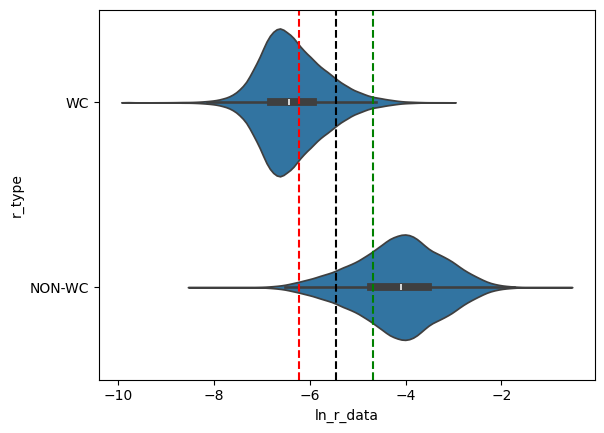

In [45]:
ax = sns.violinplot(x="ln_r_data", y="r_type", data=df)
plt.axvline(x=-4.68, color='green', linestyle='--') # 10% probability threshold (0.00927901)
plt.axvline(x=-5.45, color='black', linestyle='--') # 50% probability threshold (0.0042963)
plt.axvline(x=-6.22, color='red', linestyle='--') # 90% probability threshold (0.00198925)

## bulges

### 1-0

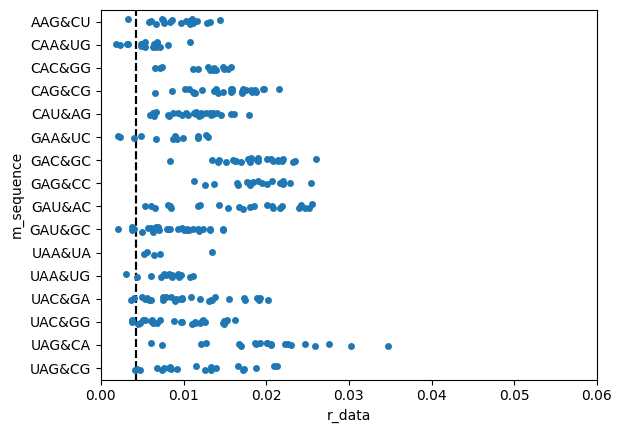

In [35]:
df_sub = df.query("m_token == '1x0' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub.sort_values("m_sequence", inplace=True)  
ax = sns.stripplot(x="r_data", y="m_sequence", data=df_sub)
ax.set_xlim([0,  0.06])
plt.axvline(x=0.0042963, color='black', linestyle='--')



In [30]:
df.query("m_token == '1x0' and r_nuc == 'A' and r_type == 'NON-WC'")["r_data"].mean()

0.012484059701492538

(0.0, 0.06)

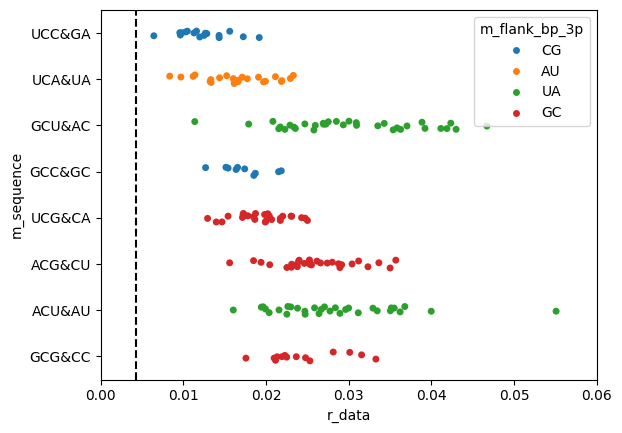

In [36]:
df_sub = df.query("m_token == '1x0' and r_nuc == 'C' and r_type == 'NON-WC'").copy()
df_sub.sort_values("r_data", inplace=True)  
ax = sns.stripplot(x="r_data", y="m_sequence", data=df_sub, hue="m_flank_bp_3p")
plt.axvline(x=0.0042963, color='black', linestyle='--')
ax.set_xlim([0,  0.06])

In [32]:
df.query("m_token == '1x0' and r_nuc == 'C' and r_type == 'NON-WC'")["r_data"].mean()

0.023439946236559143

<Axes: xlabel='r_nuc', ylabel='r_data'>

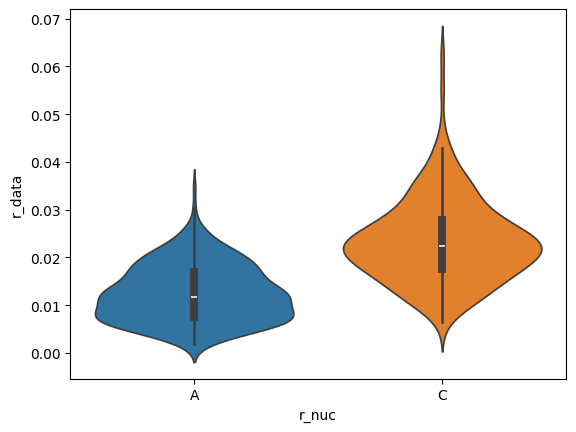

In [9]:
df_sub = df.query("m_token == '1x0' and r_type == 'NON-WC'").copy()
sns.violinplot(x="r_nuc", y="r_data", data=df_sub, hue="r_nuc")


In [10]:
df_sub_1 = df.query("m_token == '1x0' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub_2 = df.query("m_token == '1x0' and r_nuc == 'C' and r_type == 'NON-WC'").copy()
ks_2samp(df_sub_1["r_data"], df_sub_2["r_data"])

KstestResult(statistic=0.546140266409886, pvalue=2.3831508825696994e-33, statistic_location=0.017050000000000003, statistic_sign=1)

### 2-0

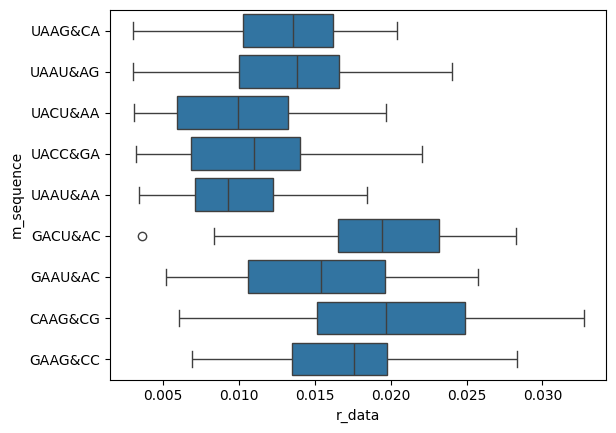

In [11]:
df_sub = df.query("m_token == '2x0' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub.sort_values("r_data", inplace=True)  
ax = sns.boxplot(x="r_data", y="m_sequence", data=df_sub)

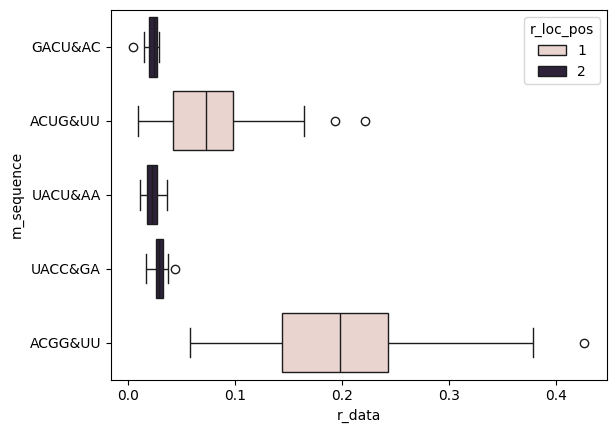

In [12]:
df_sub = df.query("m_token == '2x0' and r_nuc == 'C' and r_type == 'NON-WC'").copy()
df_sub.sort_values("r_data", inplace=True)  
ax = sns.boxplot(x="r_data", y="m_sequence", data=df_sub, hue="r_loc_pos")

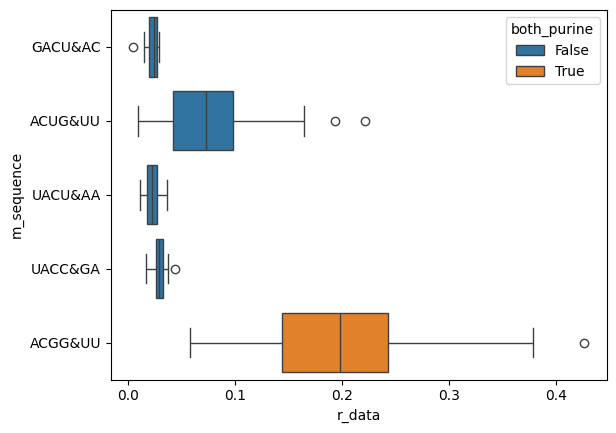

In [13]:
ax = sns.boxplot(x="r_data", y="m_sequence", data=df_sub, hue="both_purine")

<Axes: xlabel='m_token', ylabel='r_data'>

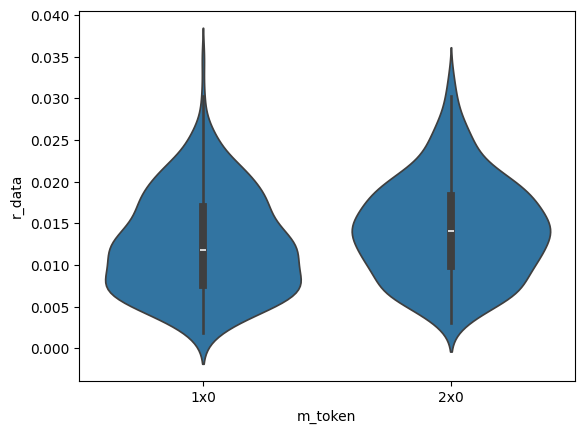

In [14]:
df_sub = df.query("(m_token == '1x0' or m_token == '2x0') and r_nuc == 'A' and r_type == 'NON-WC'").copy()
sns.violinplot(x="m_token", y="r_data", data=df_sub)


### 3-0

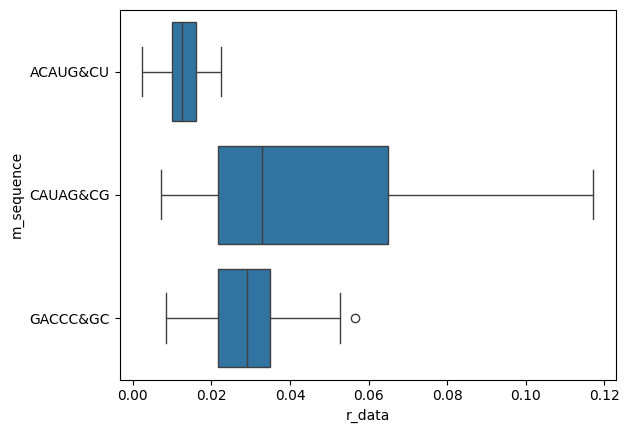

In [15]:
df_sub = df.query("m_token == '3x0' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub.sort_values("r_data", inplace=True)  
ax = sns.boxplot(x="r_data", y="m_sequence", data=df_sub)

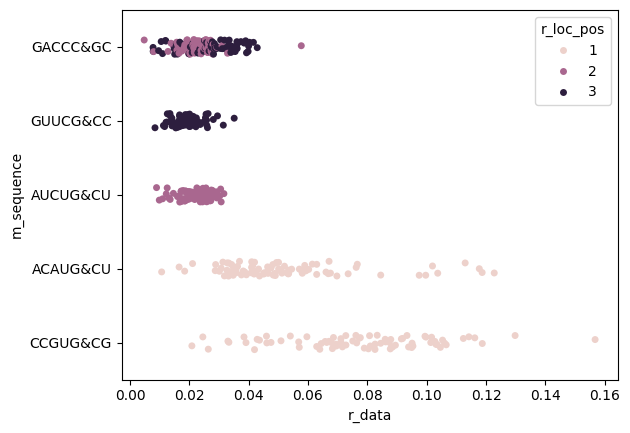

In [16]:
df_sub = df.query("m_token == '3x0' and r_nuc == 'C' and r_type == 'NON-WC'").copy()
df_sub.sort_values("r_data", inplace=True)  
ax = sns.stripplot(x="r_data", y="m_sequence", data=df_sub, hue="r_loc_pos")

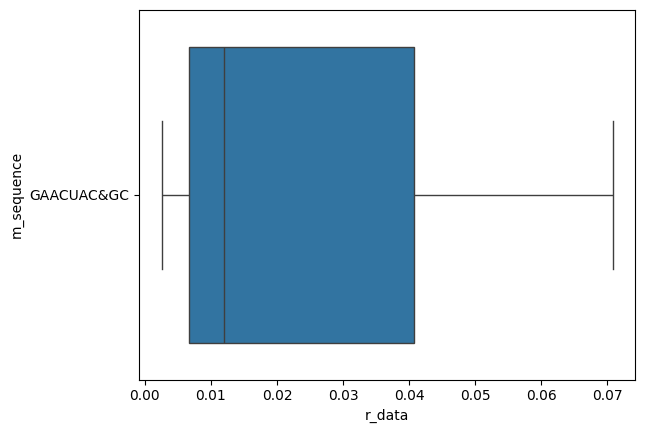

In [17]:
df_sub = df.query("m_token == '5x0' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub.sort_values("r_data", inplace=True)  
ax = sns.boxplot(x="r_data", y="m_sequence", data=df_sub)

## mismatches

### 1x1

### C mismatches

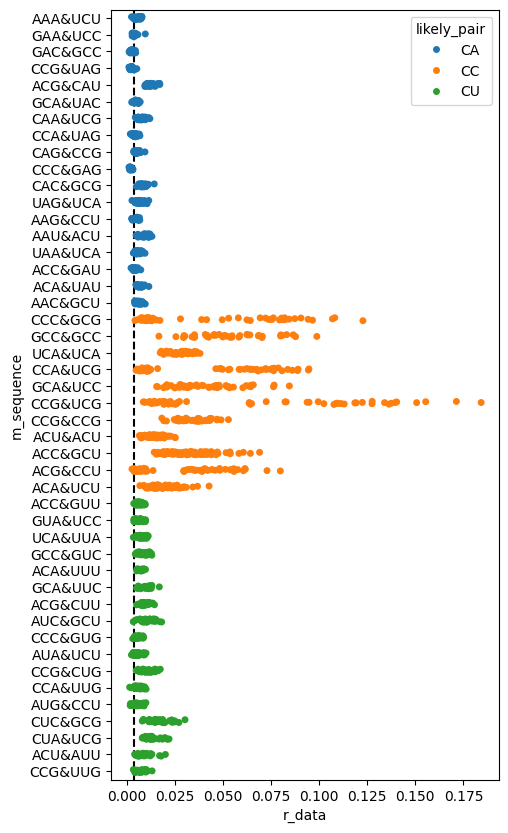

In [18]:
fig, ax = plt.subplots(figsize=(5, 10))
df_sub = df.query("m_token == '1x1' and r_nuc == 'C' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
df_sub.sort_values("likely_pair", inplace=True)  
ax = sns.stripplot(x="r_data", y="m_sequence", data=df_sub, hue='likely_pair', ax=ax)
plt.axvline(x=0.00351752, color='black', linestyle='--')

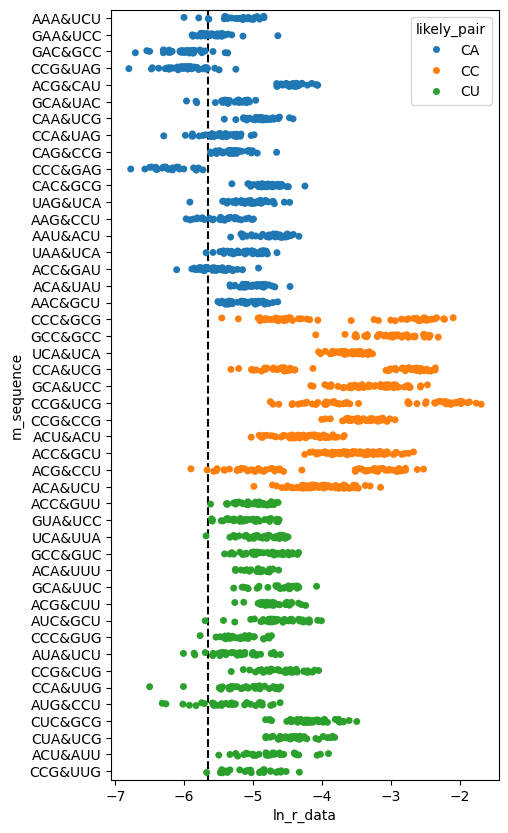

In [84]:
fig, ax = plt.subplots(figsize=(5, 10))
df_sub = df.query("m_token == '1x1' and r_nuc == 'C' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
df_sub.sort_values("likely_pair", inplace=True)  
ax = sns.stripplot(x="ln_r_data", y="m_sequence", data=df_sub, hue='likely_pair', ax=ax)
plt.axvline(x=-5.65, color='black', linestyle='--')

<Axes: xlabel='r_data', ylabel='stack'>

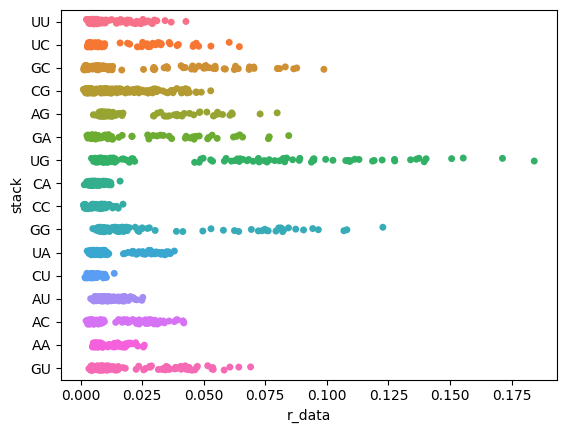

In [85]:
sns.stripplot(x="r_data", y="stack", data=df_sub, hue="stack")

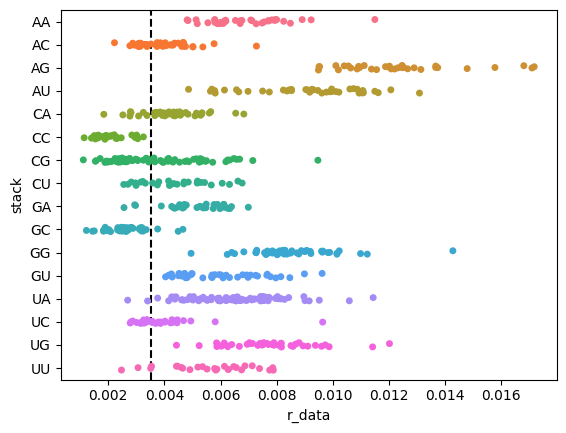

In [98]:
df_sub_2 = df_sub.query('likely_pair == "CA"').copy()
df_sub_2.sort_values("stack", inplace=True)  
sns.stripplot(x="r_data", y="stack", data=df_sub_2, hue="stack")
plt.axvline(x=0.00351752, color='black', linestyle='--')

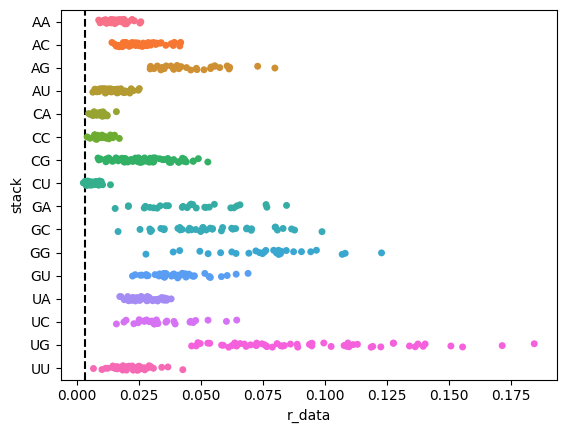

In [102]:
df_sub_2 = df_sub.query('likely_pair == "CC"').copy()
df_sub_2.sort_values("stack", inplace=True)  
sns.stripplot(x="r_data", y="stack", data=df_sub_2, hue="stack")
plt.axvline(x=0.00351752, color='black', linestyle='--')

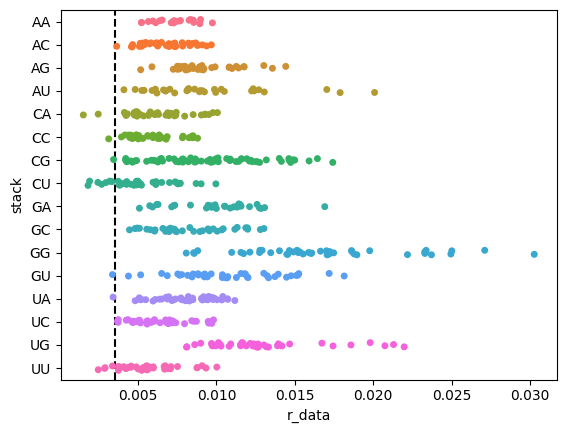

In [99]:
df_sub_2 = df_sub.query('likely_pair == "CU"').copy()
df_sub_2.sort_values("stack", inplace=True)  
sns.stripplot(x="r_data", y="stack", data=df_sub_2, hue="stack")
plt.axvline(x=0.00351752, color='black', linestyle='--')

In [21]:
count_wc = 0
count_non_wc = 0
for m_sequence, g in df_sub.query('likely_pair == "CA"').groupby("m_sequence"):
    ks1, p_val = ks_2samp(g["ln_r_data"], df_wc["ln_r_data"])
    ks2, p_val = ks_2samp(g["ln_r_data"], df_non_wc["ln_r_data"])
    if ks1 < ks2:
        print(m_sequence, ks1, ks2, p_val)
        count_wc += 1
    else:
        count_non_wc += 1
count_wc, count_non_wc

AAA&UCU 0.7686975626983318 0.7845498291885538 3.7428432345674485e-18
AAG&CCU 0.7362468322601639 0.8236564669580869 2.0602265446675215e-21
ACC&GAU 0.7437449317336511 0.8345014632234997 4.30907917390388e-33
CCA&UAG 0.7175544555431749 0.8214818352128714 3.690833695053983e-30
CCC&GAG 0.3844273014892166 0.9459207287955038 1.2384041879205078e-34
CCG&UAG 0.5068430897505207 0.8953971146520925 1.602507404975958e-45
GAA&UCC 0.7688067604744954 0.8290727347766054 2.2130227942741866e-26
GAC&GCC 0.5016418013469675 0.8980053631120744 4.345333311123975e-39
GCA&UAC 0.7791075736210975 0.8159938287477501 1.6568385813232065e-24


(9, 9)

#### A mismatches

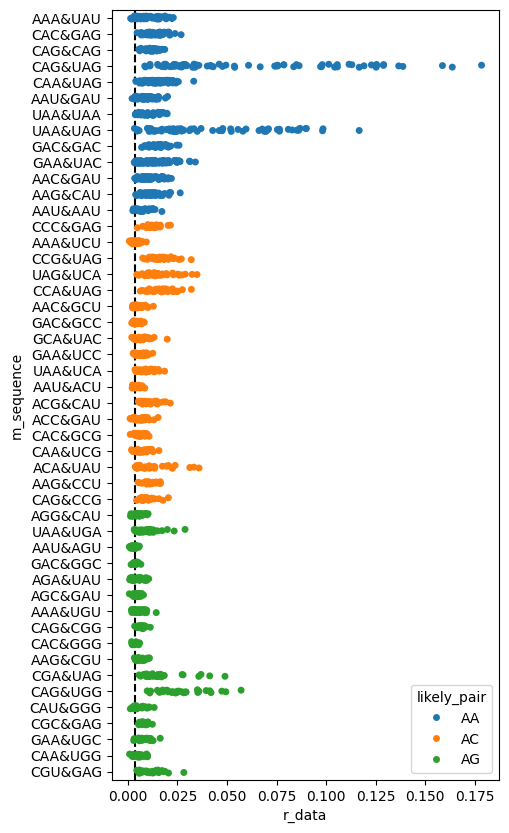

In [103]:
fig, ax = plt.subplots(figsize=(5, 10))
df_sub = df.query("m_token == '1x1' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
df_sub.sort_values("likely_pair", inplace=True)  
ax = sns.stripplot(x="r_data", y="m_sequence", data=df_sub, hue='likely_pair', ax=ax)
plt.axvline(x=0.00351752, color='black', linestyle='--')

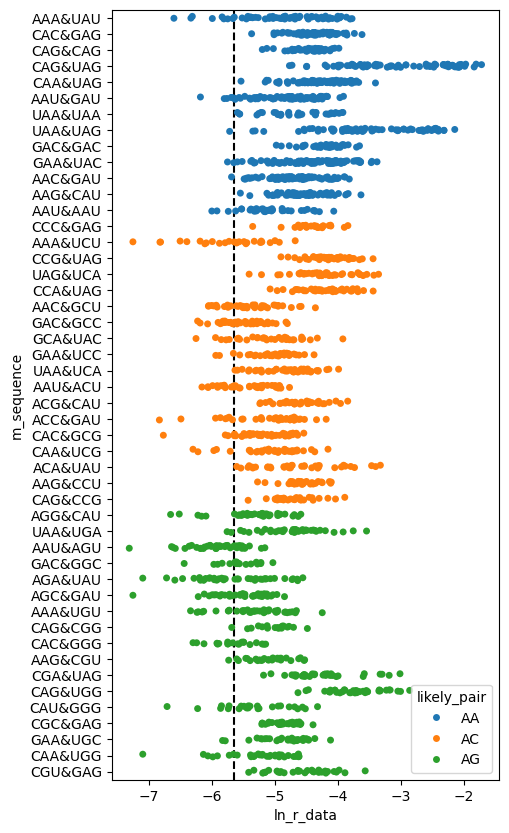

In [24]:
fig, ax = plt.subplots(figsize=(5, 10))
df_sub = df.query("m_token == '1x1' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
df_sub.sort_values("likely_pair", inplace=True)  
ax = sns.stripplot(x="ln_r_data", y="m_sequence", data=df_sub, hue='likely_pair', ax=ax)
plt.axvline(x=-5.65, color='black', linestyle='--')

In [25]:
count_wc = 0
count_non_wc = 0
for m_sequence, g in df_sub.groupby("m_sequence"):
    ks1, p_val = ks_2samp(g["ln_r_data"], df_wc["ln_r_data"])
    ks2, p_val = ks_2samp(g["ln_r_data"], df_non_wc["ln_r_data"])
    if ks1 < ks2:
        print(m_sequence, ks1, ks2, p_val)
        count_wc += 1
    else:
        count_non_wc += 1
count_wc, count_non_wc

AAA&UCU 0.45563009490711065 0.7703758123917548 2.4706946569223307e-17
AAA&UGU 0.675026165988863 0.705074140738836 1.6334595067589606e-21
AAU&ACU 0.6738437103243367 0.7767264588856446 1.3090324038953905e-26
AAU&AGU 0.45710574695827033 0.8590383131910517 5.86537635086884e-37
AGA&UAU 0.516758441319395 0.6983151501793826 4.915887424645133e-21
AGC&GAU 0.6321578594460276 0.7920884913492268 2.5137119971086275e-27
CAA&UGG 0.666060749115005 0.7143151012011901 5.021028938525127e-17
CAC&GGG 0.6067866052675692 0.8567534805128016 2.7375191068020418e-17
GAC&GCC 0.6865194797511167 0.7728464901002828 5.151365687283568e-25
GAC&GGC 0.6852521243253875 0.8315982808654446 4.437963019406426e-15


(10, 38)

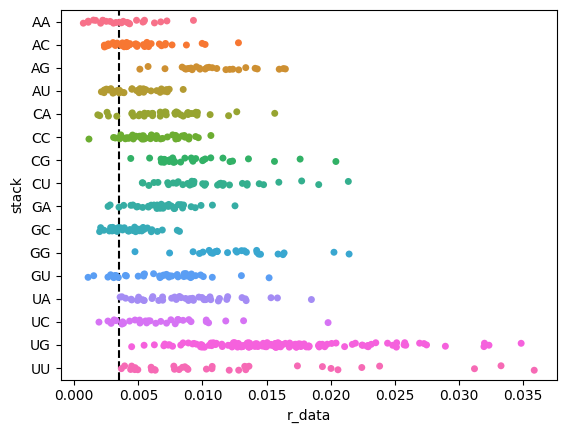

In [104]:
df_sub_2 = df_sub.query('likely_pair == "AC"').copy()
df_sub_2.sort_values("stack", inplace=True)  
sns.stripplot(x="r_data", y="stack", data=df_sub_2, hue="stack")
plt.axvline(x=0.00351752, color='black', linestyle='--')

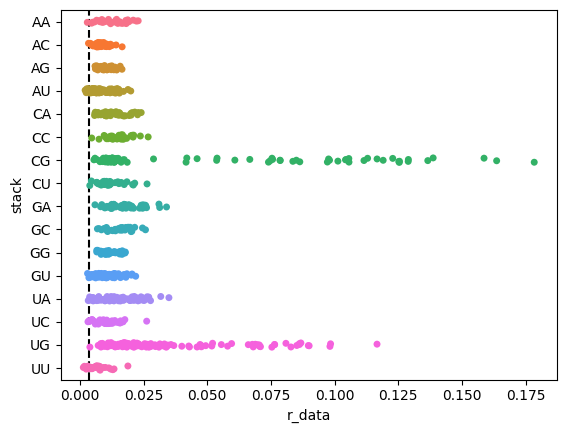

In [105]:
df_sub_2 = df_sub.query('likely_pair == "AA"').copy()
df_sub_2.sort_values("stack", inplace=True)  
sns.stripplot(x="r_data", y="stack", data=df_sub_2, hue="stack")
plt.axvline(x=0.00351752, color='black', linestyle='--')

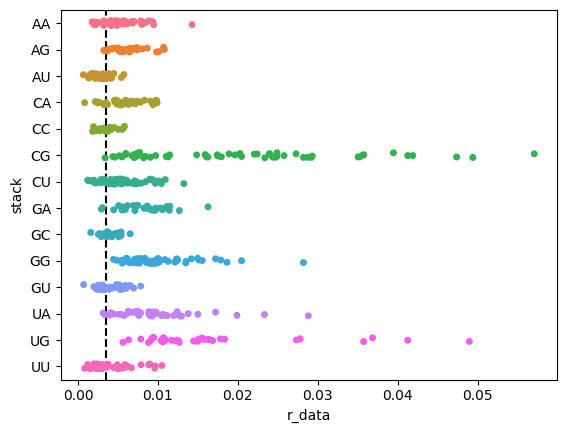

In [106]:
df_sub_2 = df_sub.query('likely_pair == "AG"').copy()
df_sub_2.sort_values("stack", inplace=True)  
sns.stripplot(x="r_data", y="stack", data=df_sub_2, hue="stack")
plt.axvline(x=0.00351752, color='black', linestyle='--')

### 2x2 mismatches

#### C mismatches

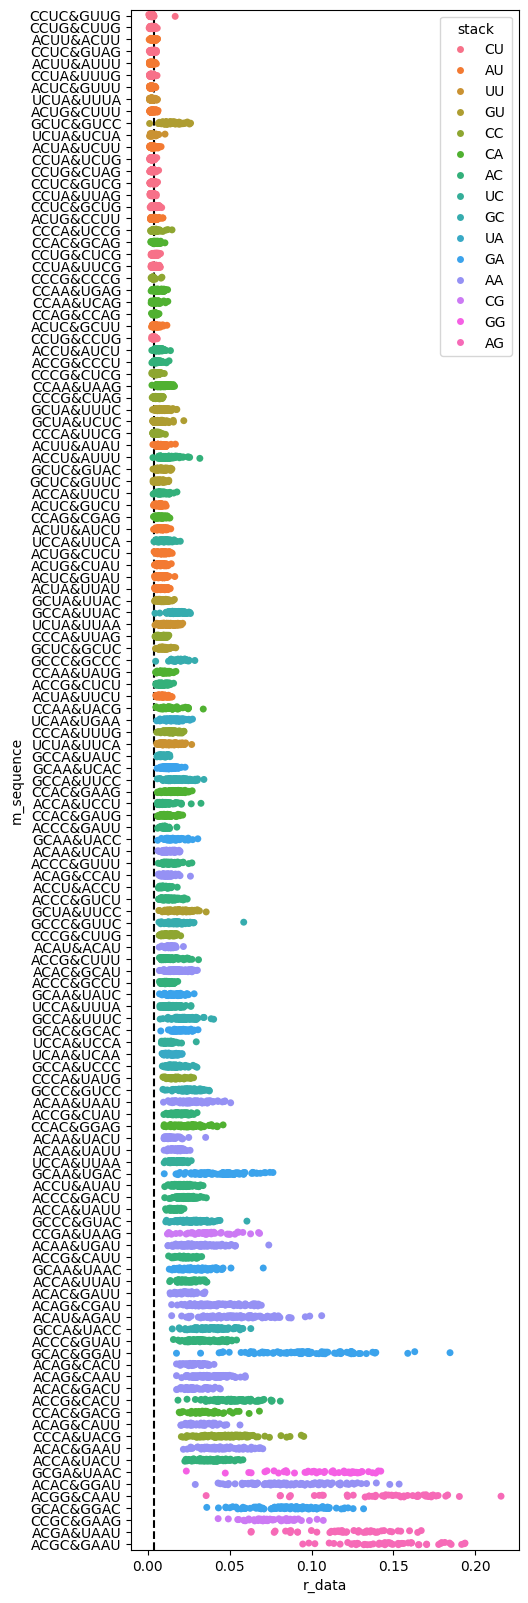

In [163]:
fig, ax = plt.subplots(figsize=(5, 20))
df_sub_pos_1 = df.query("m_token == '2x2' and r_nuc == 'C' and r_type == 'NON-WC' and r_loc_pos == 1").copy()
df_sub_pos_1["m_type"] = "pos_1"
df_sub_pos_1["stack"] = df_sub_pos_1["p5_res"] + df_sub_pos_1["p3_res"]
df_sub_pos_1.sort_values("r_data", inplace=True)  
ax = sns.stripplot(x="r_data", y="m_sequence", data=df_sub_pos_1, ax=ax, hue="stack")
plt.axvline(x=0.00351752, color='black', linestyle='--')

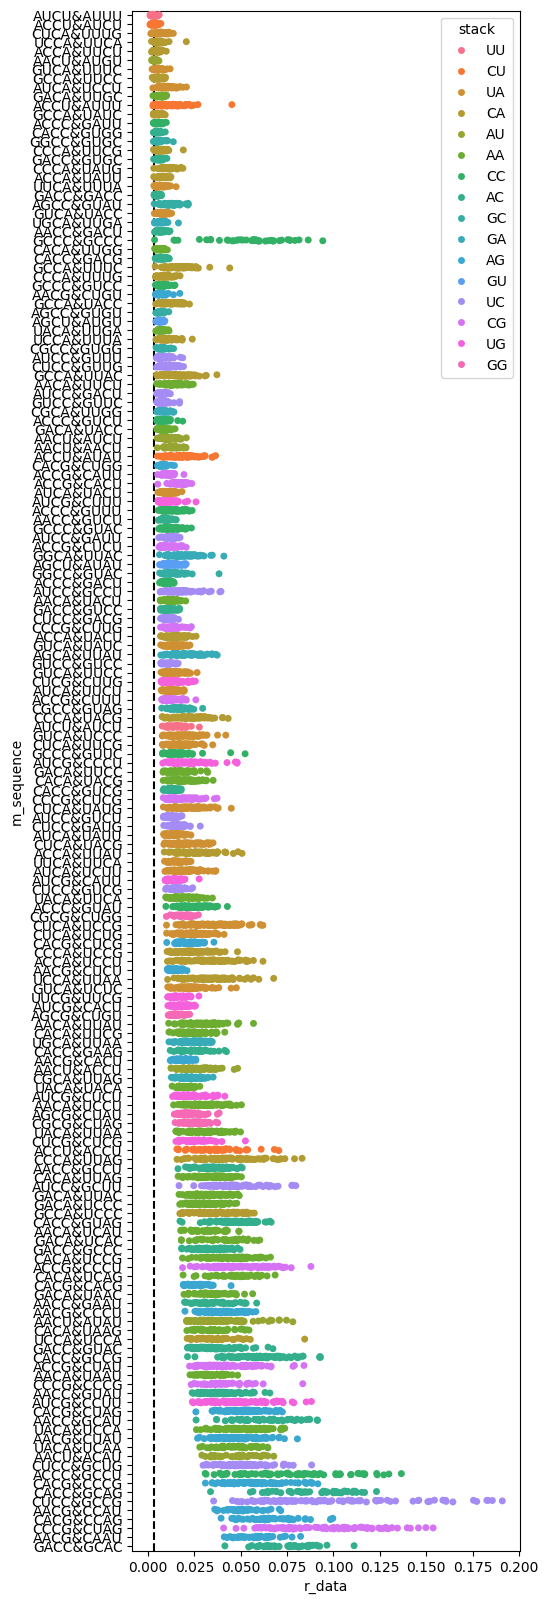

In [164]:
fig, ax = plt.subplots(figsize=(5, 20))
df_sub_pos_2 = df.query("m_token == '2x2' and r_nuc == 'C' and r_type == 'NON-WC' and r_loc_pos == 2").copy()
df_sub_pos_2["m_type"] = "pos_2"
df_sub_pos_2["stack"] = df_sub_pos_2["p5_res"] + df_sub_pos_2["p3_res"]
df_sub_pos_2.sort_values("r_data", inplace=True)  
ax = sns.stripplot(x="r_data", y="m_sequence", data=df_sub_pos_2, ax=ax, hue="stack")
plt.axvline(x=0.00351752, color='black', linestyle='--')

<Axes: xlabel='r_data', ylabel='stack'>

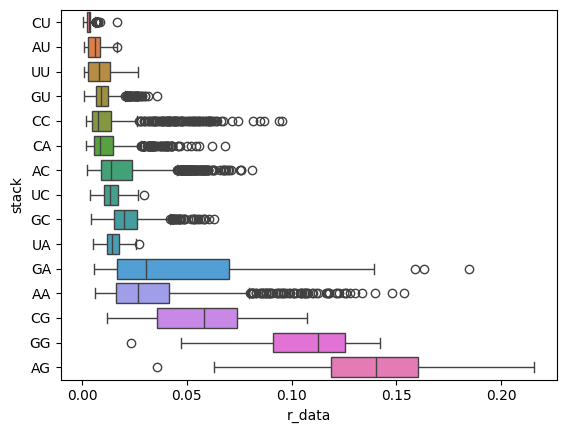

In [166]:
sns.boxplot(x="r_data", y="stack", data=df_sub_pos_1, hue="stack")

<Axes: xlabel='r_data', ylabel='p3_res'>

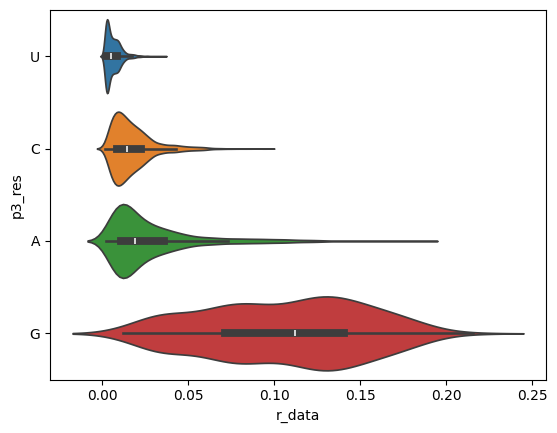

In [129]:
sns.violinplot(x="r_data", y="p3_res", data=df_sub_pos_1, hue="p3_res")

<Axes: xlabel='r_data', ylabel='stack'>

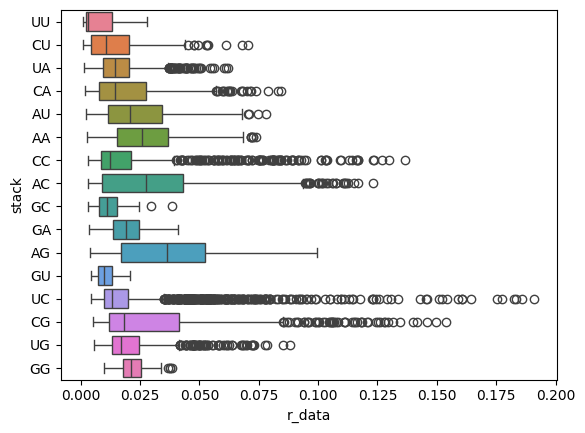

In [165]:
sns.boxplot(x="r_data", y="stack", data=df_sub_pos_2, hue="stack")

<Axes: xlabel='r_data', ylabel='p3_res'>

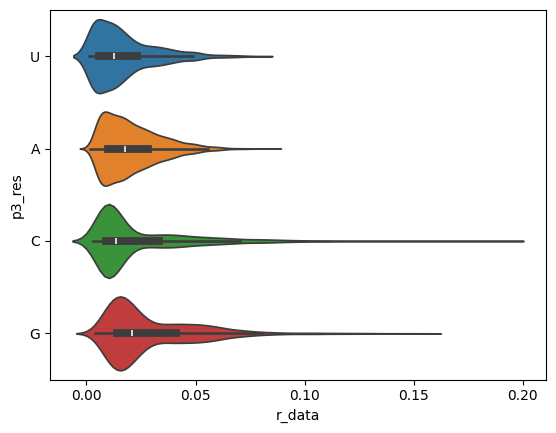

In [131]:
sns.violinplot(x="r_data", y="p3_res", data=df_sub_pos_2, hue="p3_res")

In [135]:
df_merge = pd.concat([df_sub_pos_1, df_sub_pos_2])

<Axes: xlabel='r_data', ylabel='stack'>

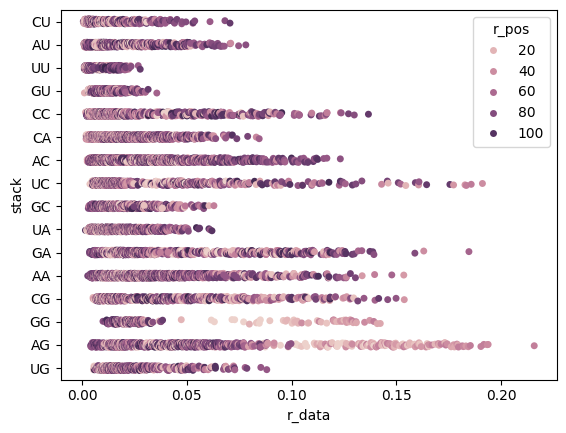

In [153]:
sns.stripplot(x="r_data", y="stack", data=df_merge, hue="r_pos")

In [157]:
df_cut = df_sub_pos_1.query("r_data > 0.15").copy()

In [162]:
df_cut["m_sequence"].unique()

array(['ACGG&CAAU', 'ACGA&UAAU', 'ACGC&GAAU', 'ACAC&GGAU', 'GCAC&GGAU'],
      dtype=object)

### A 2-2 mismatches

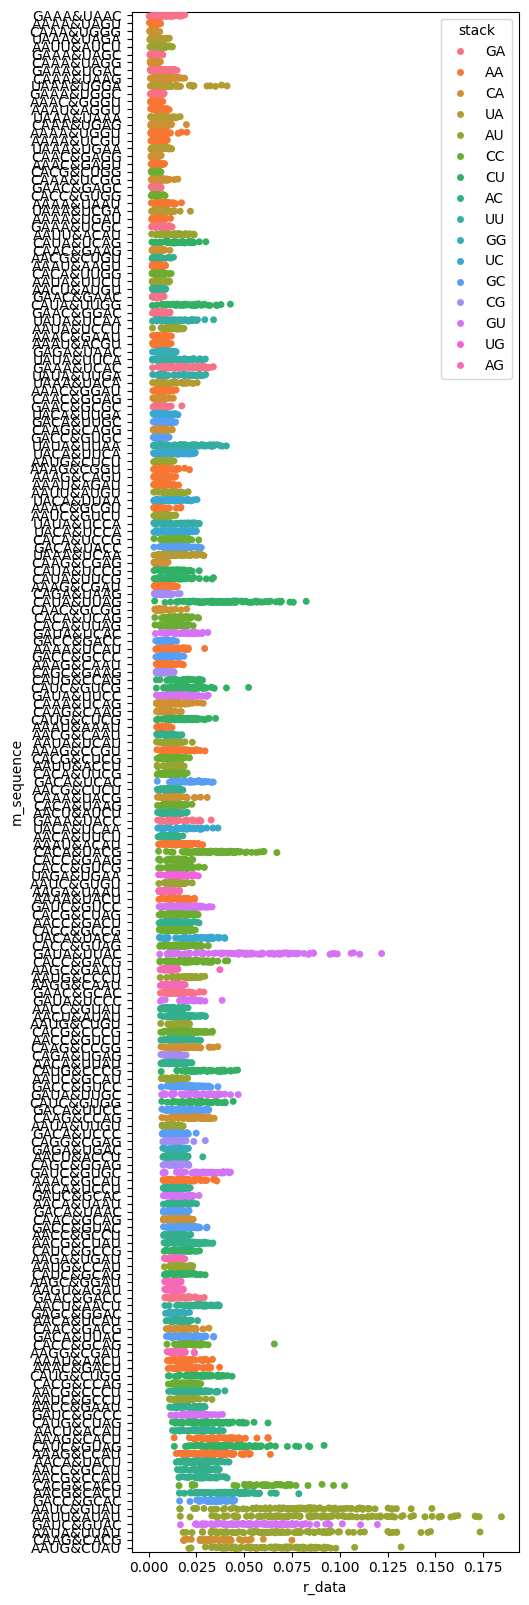

In [146]:
fig, ax = plt.subplots(figsize=(5, 20))
df_sub_pos_1 = df.query("m_token == '2x2' and r_nuc == 'A' and r_type == 'NON-WC' and r_loc_pos == 1").copy()
df_sub_pos_1["m_type"] = "pos_1"
df_sub_pos_1["stack"] = df_sub_pos_1["p5_res"] + df_sub_pos_1["p3_res"]
df_sub_pos_1.sort_values("r_data", inplace=True)  
ax = sns.stripplot(x="r_data", y="m_sequence", data=df_sub_pos_1, ax=ax, hue="stack")

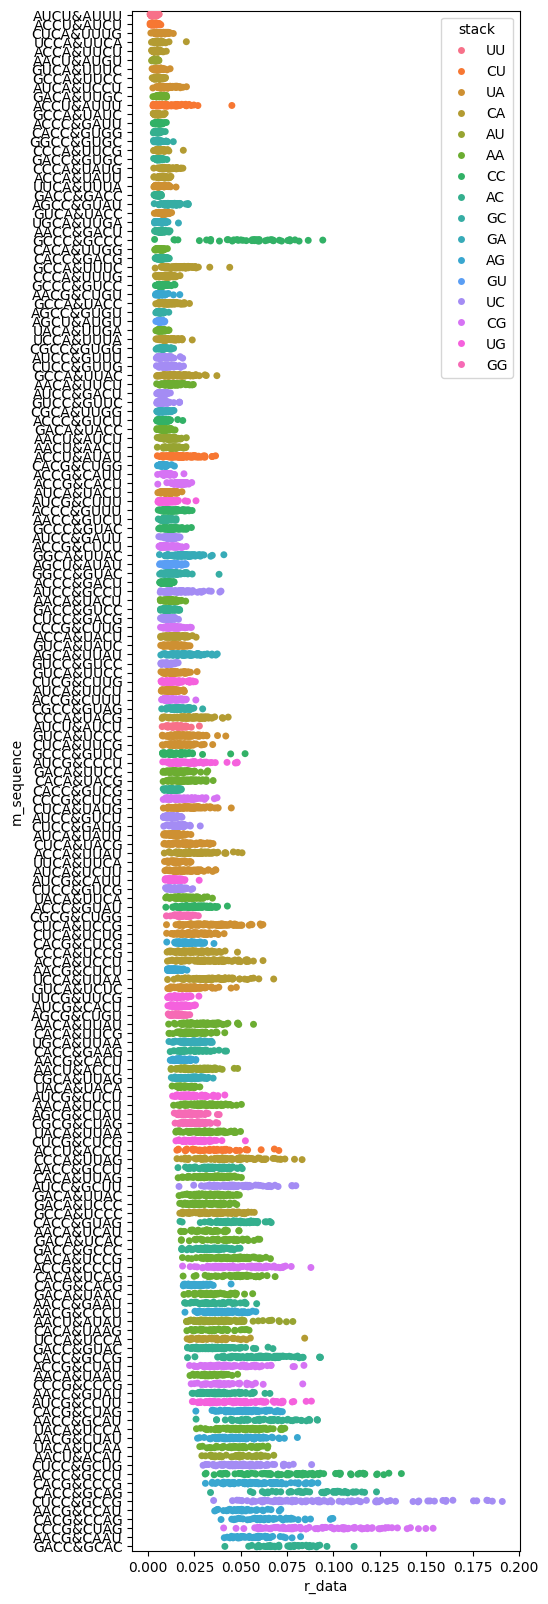

In [148]:
fig, ax = plt.subplots(figsize=(5, 20))
df_sub_pos_2 = df.query("m_token == '2x2' and r_nuc == 'C' and r_type == 'NON-WC' and r_loc_pos == 2").copy()
df_sub_pos_2["m_type"] = "pos_2"
df_sub_pos_2["stack"] = df_sub_pos_2["p5_res"] + df_sub_pos_2["p3_res"]
df_sub_pos_2.sort_values("r_data", inplace=True)  
ax = sns.stripplot(x="r_data", y="m_sequence", data=df_sub_pos_2, ax=ax, hue="stack")

<Axes: xlabel='r_data', ylabel='stack'>

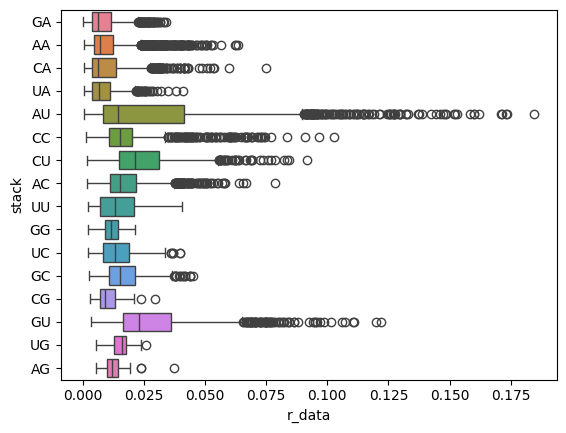

In [150]:
sns.boxplot(x="r_data", y="stack", data=df_sub_pos_1, hue="stack")

<Axes: xlabel='r_data', ylabel='stack'>

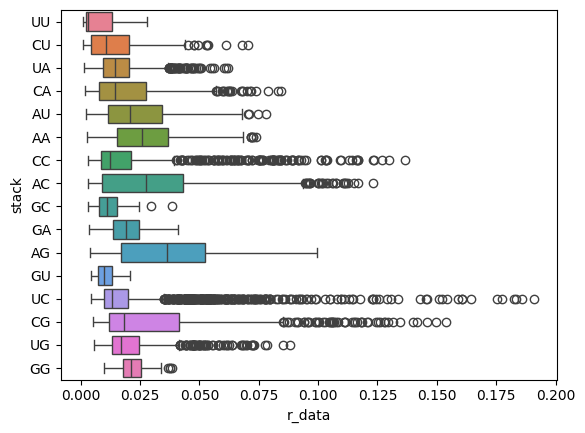

In [151]:
sns.boxplot(x="r_data", y="stack", data=df_sub_pos_2, hue="stack")

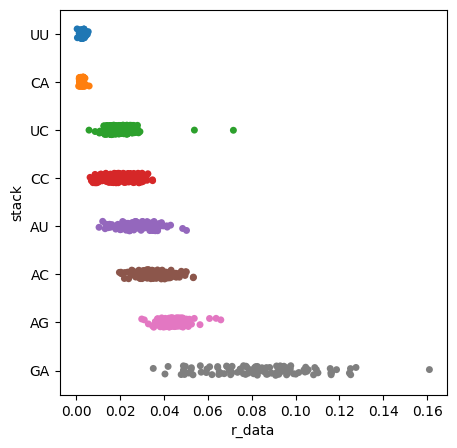

In [144]:
fig, ax = plt.subplots(figsize=(5, 5))
df_sub = df.query("m_token == '3x3' and r_nuc == 'C' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
df_sub.sort_values("r_data", inplace=True)  
ax = sns.stripplot(x="r_data", y="stack", data=df_sub, ax=ax, hue="stack")

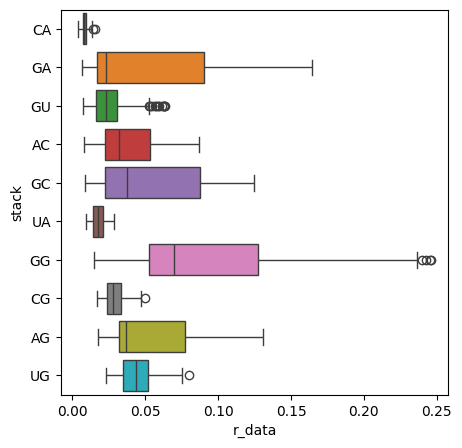

In [167]:
fig, ax = plt.subplots(figsize=(5, 5))
df_sub = df.query("m_token == '3x3' and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
df_sub.sort_values("r_data", inplace=True)  
ax = sns.boxplot(x="r_data", y="stack", data=df_sub, ax=ax, hue="stack")

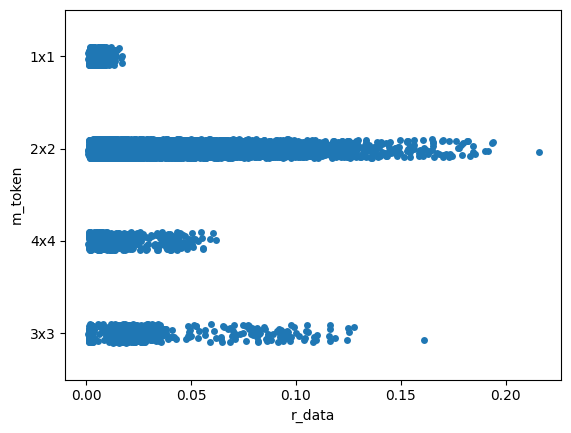

In [32]:
tokens = ["1x1", "2x2", "3x3", "4x4"]
df_sub = df.query("(m_token in @tokens) and (likely_pair == 'CA' or likely_pair == 'AC') and r_nuc == 'C' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
ax = sns.stripplot(x="r_data", y="m_token", data=df_sub)

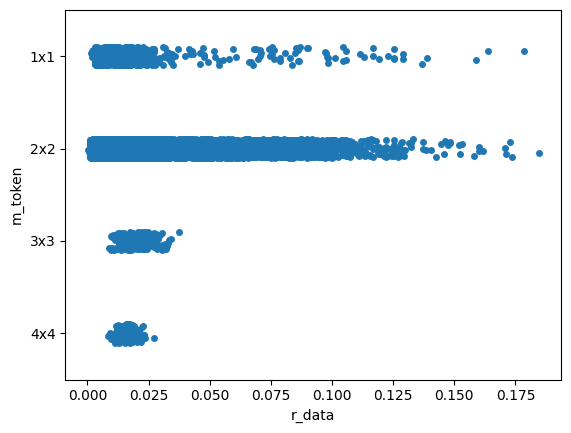

In [33]:
tokens = ["1x1", "2x2", "3x3", "4x4"]
df_sub = df.query("(m_token in @tokens) and (likely_pair == 'AA' or likely_pair == 'AA') and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
ax = sns.stripplot(x="r_data", y="m_token", data=df_sub)

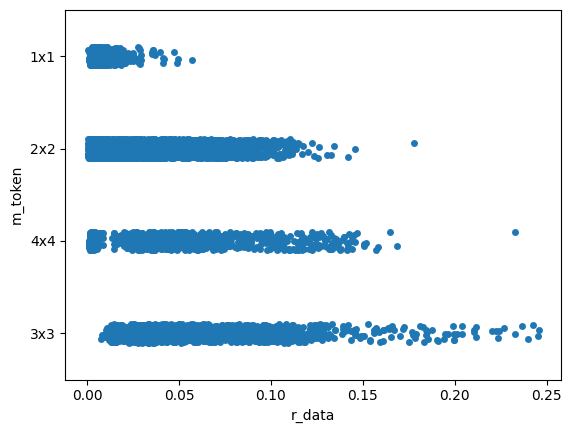

In [34]:
tokens = ["1x1", "2x2", "3x3", "4x4"]
df_sub = df.query("(m_token in @tokens) and (likely_pair == 'AG' or likely_pair == 'GA') and r_nuc == 'A' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
ax = sns.stripplot(x="r_data", y="m_token", data=df_sub)

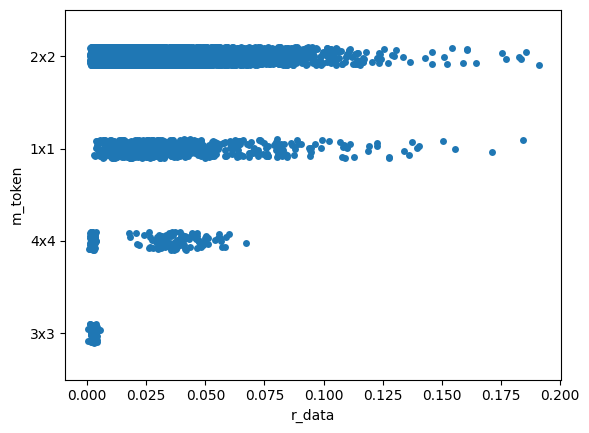

In [35]:
tokens = ["1x1", "2x2", "3x3", "4x4"]
df_sub = df.query("(m_token in @tokens) and (likely_pair == 'CC' or likely_pair == 'CC') and r_nuc == 'C' and r_type == 'NON-WC'").copy()
df_sub["stack"] = df_sub["p5_res"] + df_sub["p3_res"]
ax = sns.stripplot(x="r_data", y="m_token", data=df_sub)

## probability

In [39]:
df_non_wc = df.query("r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C')").copy()
df_sub_1 = df_non_wc.query("ln_r_data < -5.46").copy()
df_sub_1.value_counts("m_token")

m_token
2x2    9300
1x1     581
4x4     578
3x2     336
3x1     264
3x3     205
5x4     181
6x3     157
4x3     105
5x3      80
2x1      36
4x2      36
1x0      18
5x0      16
2x0      13
5x1       8
3x0       1
4x1       1
dtype: int64

In [40]:
df_sub_1.value_counts("likely_pair")

likely_pair
AG    3116
CU    1825
AA    1428
      1252
UU    1005
CC     905
CA     887
UC     789
AC     387
GA     251
GG      71
dtype: int64

In [41]:
df_non_wc = df.query("r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C')").copy()
count = 0
total = 0
for [r_loc_pos, m_sequence], g in df_non_wc.groupby(["r_loc_pos", "m_sequence"]):
    avg = g["ln_r_data"].mean()
    if avg < -5.46:
        count += 1
    total += 1
total, count, count/total * 100

(1745, 130, 7.4498567335243555)

In [42]:
df_non_wc = df.query("r_type == 'WC' and (r_nuc == 'A' or r_nuc == 'C')").copy()
count = 0
total = 0
for [r_loc_pos, m_sequence], g in df_non_wc.groupby(["r_loc_pos", "m_sequence"]):
    avg = g["ln_r_data"].mean()
    if avg > -5.46:
        count += 1
    total += 1
total, count, count/total * 100

(1378, 121, 8.780841799709723)

In [43]:
df_non_wc = df.query("r_type == 'NON-WC' and (r_nuc == 'A' or r_nuc == 'C')").copy()
df_non_wc_under = df_non_wc.query("ln_r_data < -5.46").copy()
df_stats = []
pairs = ['AA', 'AC', 'CA', 'GA', 'AG', 'CU', 'CC']
for p in pairs:
    df_sub = df_non_wc_under.query(f"likely_pair == '{p}'")
    df_sub_under = df_non_wc.query(f"likely_pair == '{p}'")
    print(p, len(df_sub), len(df_sub_under), len(df_sub)/len(df_sub_under) * 100)

AA 1428 20854 6.8476071736837065
AC 387 14388 2.689741451209341
CA 887 15131 5.862137333950169
GA 251 6022 4.168050481567585
AG 3116 13387 23.276312840815716
CU 1825 16797 10.865035422992202
CC 905 11989 7.548586204020352


In [44]:
df_stats = []
pairs = ['AA', 'AC', 'CA', 'GA', 'AG', 'CU', 'UC', 'CC']
for p in pairs:
    df_sub = df_non_wc_under.query(f"likely_pair == '{p}' and m_token == '1x1'")
    df_sub_under = df_non_wc.query(f"likely_pair == '{p}' and m_token == '1x1'")
    if len(df_sub_under) == 0:
        continue
    print(p, len(df_sub), len(df_sub_under), len(df_sub)/len(df_sub_under) * 100)

AA 39 866 4.503464203233257
AC 114 674 16.913946587537094
CA 218 674 32.34421364985163
AG 164 563 29.129662522202487
CU 41 624 6.570512820512821
CC 5 672 0.744047619047619


## stacking

/var/folders/wj/4ksnmwbd59g7774kql3ctq7h0000gq/T/ipykernel_45073/3908088673.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_wc["stack"] = df_non_wc["p5_res"] + df_non_wc["p3_res"]


<Axes: xlabel='ln_r_data', ylabel='p5_res'>

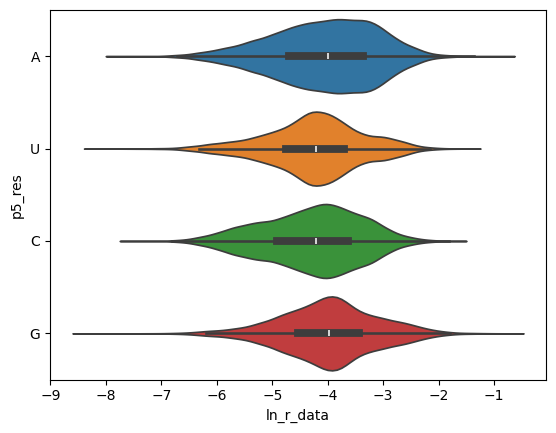

In [72]:
df_non_wc["stack"] = df_non_wc["p5_res"] + df_non_wc["p3_res"]
sns.violinplot(x="ln_r_data", y="p5_res", data=df_non_wc, hue="p5_res")


<Axes: xlabel='ln_r_data', ylabel='p3_res'>

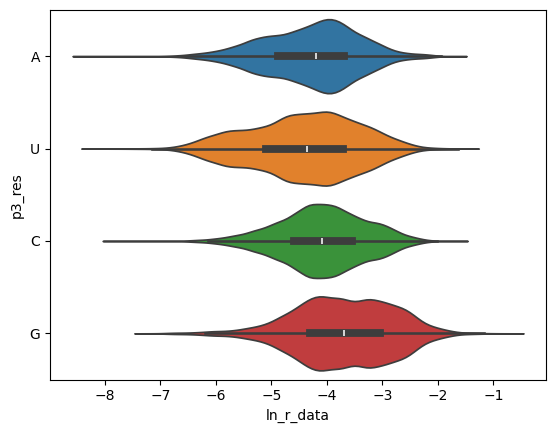

In [71]:
sns.violinplot(x="ln_r_data", y="p3_res", data=df_non_wc, hue="p3_res")


<Axes: xlabel='ln_r_data', ylabel='stack'>

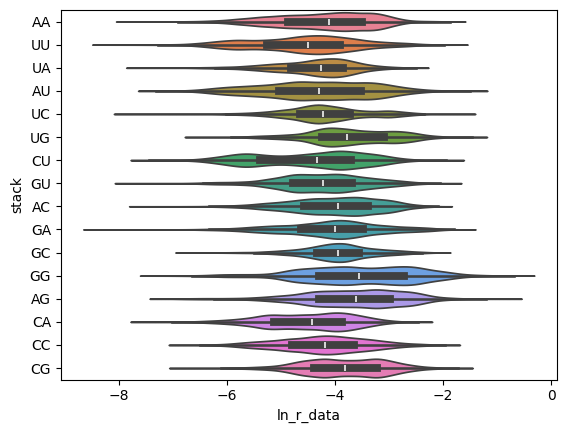

In [70]:
sns.violinplot(x="ln_r_data", y="stack", data=df_non_wc, hue="stack")


In [78]:
df_non_wc_pair = df_non_wc.query("likely_pair != ''").copy()


<Axes: xlabel='ln_r_data', ylabel='p5_res'>

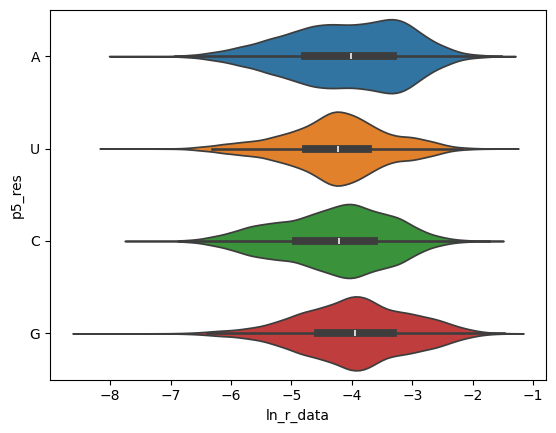

In [79]:
sns.violinplot(x="ln_r_data", y="p5_res", data=df_non_wc_pair, hue="p5_res")


<Axes: xlabel='ln_r_data', ylabel='stack'>

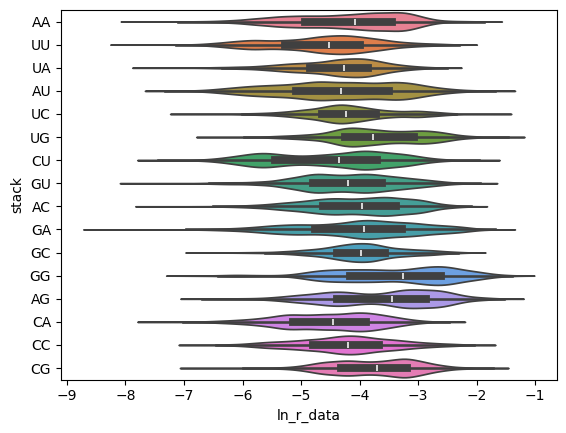

In [82]:
sns.violinplot(x="ln_r_data", y="stack", data=df_non_wc_pair, hue="stack")


In [117]:
df_non_wc_pair = df_non_wc.query("likely_pair != '' and r_nuc == 'C'").copy()


<Axes: xlabel='r_data', ylabel='p3_res'>

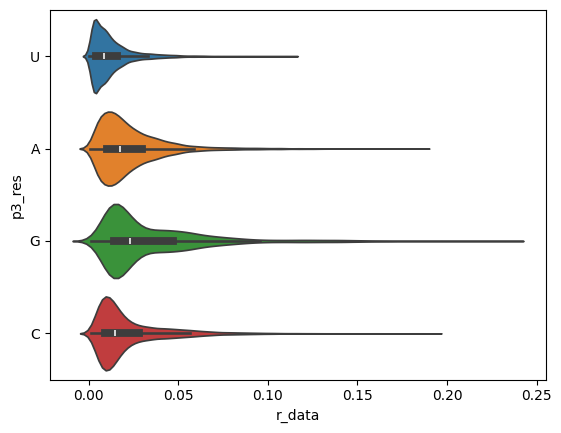

In [120]:
sns.violinplot(x="r_data", y="p3_res", data=df_non_wc_pair, hue="p3_res")

In [179]:
df_high = df_non_wc.query("r_data > 0.15").copy()

In [190]:
for (nuc, m_token), full_g in df_non_wc.groupby(["r_nuc", "m_token"]):
    g = df_high.query(f"r_nuc == '{nuc}' and m_token == '{m_token}'")
    if len(g) == 0:
        continue
    print(f"{nuc} {m_token} {g.shape[0]}/{full_g.shape[0]}, percentage: {g.shape[0]/full_g.shape[0]*100}")

A 1x1 3/2103, percentage: 0.14265335235378032
A 2x1 80/2569, percentage: 3.1140521603736864
A 2x2 16/55600, percentage: 0.028776978417266185
A 3x2 1/3319, percentage: 0.030129557095510694
A 3x3 63/2385, percentage: 2.6415094339622645
A 4x4 8/1970, percentage: 0.40609137055837563
C 1x1 4/1970, percentage: 0.20304568527918782
C 2x0 23/175, percentage: 13.142857142857142
C 2x2 111/49361, percentage: 0.2248738882923766
C 3x0 1/482, percentage: 0.2074688796680498
C 3x3 1/1035, percentage: 0.0966183574879227


In [189]:
df_high["stack"].value_counts()

GG    182
AG     75
AU     15
UC     13
UG     11
GA      8
CG      5
AA      1
UU      1
Name: stack, dtype: int64

In [185]:
df_non_wc["stack"].value_counts()

AC    11183
UA    10462
UC    10109
GA     9940
AA     9901
AU     9303
UU     9031
CC     8660
CA     8628
AG     8534
GC     8186
CU     7299
GU     6778
UG     6680
CG     6164
GG     5257
Name: stack, dtype: int64